Author type analysis across all journals
===

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

from collections import Counter
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [6]:
import sys
sys.path.append("/home/srivbane/levon003/repos/qual-health-journeys/annotation_data")
import journal as journal_utils
import db as db_utils

In [7]:
general_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
vw_working_dir = os.path.join(general_working_dir, "vw")
os.makedirs(vw_working_dir, exist_ok=True)

In [8]:
preds_filepath = os.path.join(vw_working_dir, "all_journal_preds.csv")
assert os.path.exists(preds_filepath)

In [13]:
s = datetime.now()
working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/extract_site_features/"
flattened_site_json_filename = os.path.join(working_dir, "site_scrubbed_flat.json")
feathered_site_df_filename = os.path.join(working_dir, "site_scrubbed.df")
site_info_df = pd.read_feather(feathered_site_df_filename)
print(datetime.now() - s)

0:00:03.547017


In [14]:
site_info_df['site_id'] = site_info_df['_id']

In [15]:
df = pd.read_csv(preds_filepath, header=None, names=['site_id', 'journal_oid', 'author_type_raw_prediction'])
len(df)

14967181

In [16]:
df.head()

,site_id,journal_oid,author_type_raw_prediction
0,96561,51b7ec228379ff4810b67aec,0.348497
1,318748,51b7ec228379ff4810b67af0,-0.331595
2,48125,51b7ec228379ff4810b67aee,-0.702102
3,318748,51b7ec228379ff4810b67af3,-0.223080
4,127715,51b7ec228379ff4810b67b09,-0.709945


In [17]:
def logistic(raw_prob):
    return 1 / (1 + np.exp(-1 * float(raw_prob) ))
df['author_type_prediction_prob'] = df.author_type_raw_prediction.map(logistic)

In [18]:
np.min(df.author_type_prediction_prob), np.max(df.author_type_prediction_prob)

(1.928749847963918e-22, 1.0)

In [19]:
df['is_predicted_patient'] = df.author_type_prediction_prob >= 0.5

In [20]:
Counter(df.is_predicted_patient)

Counter({True: 4242542, False: 10724639})

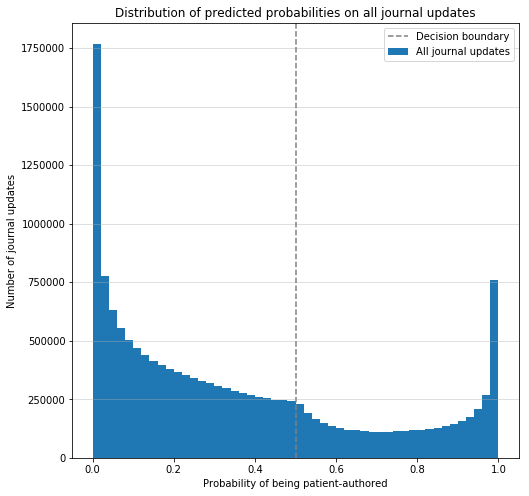

In [21]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of predicted probabilities on all journal updates"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = df.author_type_prediction_prob
patches = plt.hist(x, bins=50, range=(0,1), label="All journal updates")
plt.axvline(0.5, color='gray', label='Decision boundary', linestyle='--')

ax.set_title(title)
ax.set_xlabel("Probability of being patient-authored")
ax.set_ylabel("Number of journal updates")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [22]:
def iter_journal_metadata():
    try:
        db = db_utils.get_journal_info_db()
        cursor = db.execute("""SELECT site_id, journal_oid, user_id, created_at, site_index
                                FROM journalMetadata""")
        num_returned = 0
        while True:
            journal = cursor.fetchone()
            if journal is None:
                return

            journal_dict = {'site_id': int(journal['site_id']),
                              'journal_oid': journal['journal_oid'],
                              'created_at': int(journal['created_at']),
                              'user_id': journal['user_id'],
                              'site_index': int(journal['site_index'])}
            num_returned += 1
            yield journal_dict
    finally:
        db.close()
        
        
def get_journal_metadata():
    metadata = []
    estimated_length = 15327592  # total number of journals
    for journal in tqdm(iter_journal_metadata(), total=estimated_length):
        metadata.append(journal)
    journal_metadata_df = pd.DataFrame(metadata)
    return journal_metadata_df

In [23]:
# surprisingly, this only takes about a minute
journal_metadata_df = get_journal_metadata()

100%|██████████| 15327592/15327592 [00:59<00:00, 257548.10it/s]


In [24]:
# merge journal metadata with journal predictions
s = datetime.now()
journal_df = pd.merge(df, journal_metadata_df, how='left', on=['site_id', 'journal_oid'], validate='one_to_one')
print(datetime.now() - s)
len(journal_df)

0:02:24.933927


14967181

In [25]:
journal_df.head()

,site_id,journal_oid,author_type_raw_prediction,author_type_prediction_prob,is_predicted_patient,created_at,site_index,user_id
0,96561,51b7ec228379ff4810b67aec,0.348497,0.586253,True,1371412342000,112,4397546
1,318748,51b7ec228379ff4810b67af0,-0.331595,0.417853,False,1371424660000,237,14542232
2,48125,51b7ec228379ff4810b67aee,-0.702102,0.331346,False,1371415944000,247,2116986
3,318748,51b7ec228379ff4810b67af3,-0.223080,0.444460,False,1371425469000,238,14542232
4,127715,51b7ec228379ff4810b67b09,-0.709945,0.329611,False,1371488839000,291,5828136


In [26]:
journal_df.sort_values(by=['site_id', 'journal_oid', 'site_index'], inplace=True)

In [27]:
%%time
# save the dataframe
journal_df_filepath = os.path.join(vw_working_dir, "journal_author_metadata.csv")
journal_df.to_csv(journal_df_filepath)

CPU times: user 2min 45s, sys: 3.69 s, total: 2min 48s
Wall time: 2min 52s


In [8]:
%%time
# read the dataframe
journal_df_filepath = os.path.join(vw_working_dir, "journal_author_metadata.csv")
journal_df = pd.read_csv(journal_df_filepath)

CPU times: user 25.3 s, sys: 2.99 s, total: 28.3 s
Wall time: 30.1 s


In [28]:
del df
del journal_metadata_df

In [30]:
df = journal_df

## Compute site proportions

In [33]:
site_proportions = []
for site_id, group in tqdm(df.groupby(by='site_id', sort=False)):
    total_journals = len(group)
    total_patient_authored = np.sum(group.is_predicted_patient)
    site_patient_proportion = total_patient_authored / total_journals
    site_proportion = {
        'site_id': site_id,
        'total_journals': total_journals,
        'total_patient_authored': total_patient_authored,
        'site_patient_proportion': site_patient_proportion
    }
    site_proportions.append(site_proportion)
len(site_proportions)

100%|██████████| 486602/486602 [04:06<00:00, 1973.70it/s]


486602

In [34]:
site_df = pd.DataFrame(site_proportions)
len(site_df)
site_df.head()

,site_id,site_patient_proportion,total_journals,total_patient_authored
0,1,0.048128,187,9
1,2,0.068966,29,2
2,4,1.000000,1,1
3,6,0.058824,17,1
4,10,0.000000,15,0


In [35]:
site_df_filepath = os.path.join(vw_working_dir, "site_proportions.feather")
site_df.to_feather(site_df_filepath)

In [32]:
site_df_filepath = os.path.join(vw_working_dir, "site_proportions.feather")
site_df = pd.read_feather(site_df_filepath)
len(site_df)

486704

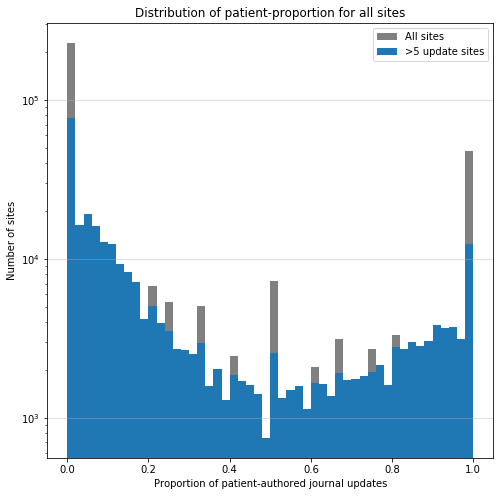

In [36]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of patient-proportion for all sites"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = site_df.site_patient_proportion
patches = plt.hist(x, bins=50, range=(0,1), label="All sites", log=True, color='gray')
plt.hist(site_df[site_df.total_journals > 5].site_patient_proportion, 
         bins=50, range=(0,1), label=">5 update sites", log=True)
#plt.axvline(0.5, color='gray', label='Decision boundary', linestyle='--')

ax.set_title(title)
ax.set_xlabel("Proportion of patient-authored journal updates")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [37]:
len(site_df[site_df.site_patient_proportion >= 0.6].site_patient_proportion) / len(site_df), \
len(site_df[(site_df.site_patient_proportion < 0.6)&(site_df.site_patient_proportion >= 0.4)].site_patient_proportion) / len(site_df), \
len(site_df[site_df.site_patient_proportion < 0.4].site_patient_proportion) / len(site_df)

(0.19924907830218536, 0.04247002683918274, 0.7582808948586319)

In [38]:
len(site_df[site_df.site_patient_proportion >= 0.9].site_patient_proportion) / len(site_df), \
len(site_df[(site_df.site_patient_proportion < 0.9)&(site_df.site_patient_proportion >= 0.1)].site_patient_proportion) / len(site_df), \
len(site_df[site_df.site_patient_proportion < 0.1].site_patient_proportion) / len(site_df)

(0.12752927443783627, 0.2689734115355054, 0.6034973140266583)

In [39]:
df = pd.merge(site_info_df, site_df, on='site_id', validate='one_to_one')
len(df)

449926

In [40]:
df.head()

,_id,age,allowList,allowList_count,bi_createHadProfile,blockList,blockList_count,calendarId,createFormSessionId,createdAt,...,theme_legacyTemplate,theme_title,title,updatedAt,userMigrationStatus,visits,site_id,site_patient_proportion,total_journals,total_patient_authored
0,1,teen,,0,-1,,0,NaN,NaN,1.117606e+12,...,flowerpower,Flower Power,Carly's Updates,1371330918000,upgraded,22802.0,1,0.048128,187,9
1,2,baby,,0,-1,,0,NaN,NaN,1.118088e+12,...,pinkflowers,Pink Flowers,Joanna Lee,1371138394000,auto-upgraded,8413.0,2,0.068966,29,2
2,103174,adult,,0,-1,,0,NaN,NaN,1.229619e+12,...,happynewyear,New Year,Dale E. Webster,1368283126000,auto-upgraded,209.0,103174,0.000000,6,0
3,4,child,,0,-1,,0,NaN,NaN,1.117606e+12,...,angels,Angels,Madelyn's Milestones,1370883816000,auto-upgraded,25777.0,4,1.000000,1,1
4,103177,adult,,0,-1,,0,NaN,NaN,1.229620e+12,...,valentinesday,Valentine,Megan McClure,1273074358000,auto-upgraded,69536.0,103177,0.142857,91,13


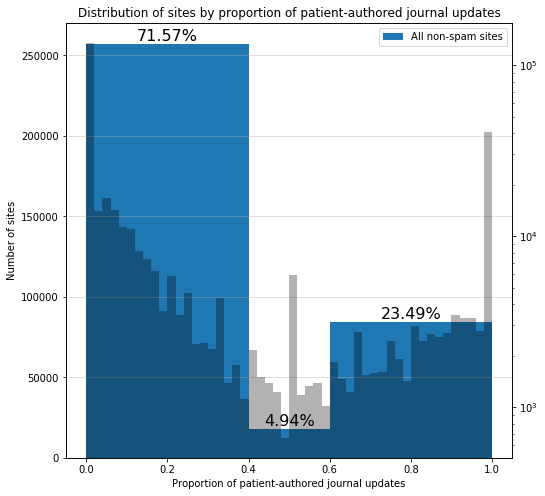

In [41]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of sites by proportion of patient-authored journal updates"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = df[df.isSpam.isna()].site_patient_proportion

lower_thresh = 0.4
upper_thresh = 0.6

bin_counts, bins, _ = plt.hist(x, bins=[0, lower_thresh, upper_thresh, 1], range=(0,1), label="All non-spam sites")
#plt.hist(df.site_patient_proportion, bins=[0, lower_thresh, upper_thresh, 1], range=(0,1), label="All sites", alpha=0.6)
ax = plt.gca()

for i, bin_count in enumerate(bin_counts):
    pct = bin_count / len(x) * 100
    ax.text((bins[i] + bins[i+1]) / 2, bin_count, "%.2f%%" % pct, 
            horizontalalignment='center', verticalalignment='bottom', fontsize=16)

ax2 = plt.gca().twinx()
ax2.hist(x, bins=50, range=(0,1), label="Detail", log=True, color='black', alpha=0.3)

ax.set_title(title)
ax.set_xlabel("Proportion of patient-authored journal updates")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

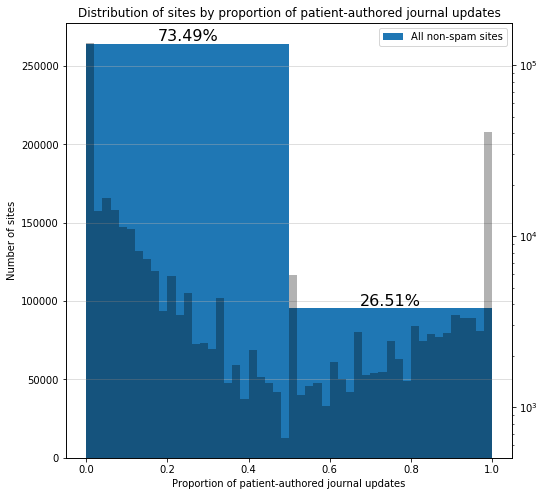

array([264191.,  95293.])

In [42]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of sites by proportion of patient-authored journal updates"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = df[df.isSpam.isna()].site_patient_proportion

upper_thresh = 0.5

bin_counts, bins, _ = plt.hist(x, bins=[0, upper_thresh, 1], range=(0,1), label="All non-spam sites")
for i, bin_count in enumerate(bin_counts):
    pct = bin_count / len(x) * 100
    ax.text((bins[i] + bins[i+1]) / 2, bin_count, "%.2f%%" % pct, 
            horizontalalignment='center', verticalalignment='bottom', fontsize=16)

ax2 = plt.gca().twinx()
ax2.hist(x, bins=50, range=(0,1), label="Detailed distribution", log=True, color='black', alpha=0.3)

ax.set_title(title)
ax.set_xlabel("Proportion of patient-authored journal updates")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()
bin_counts

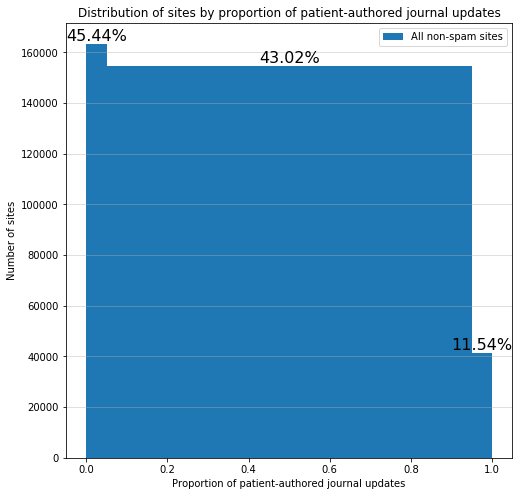

In [20]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of sites by proportion of patient-authored journal updates"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = df[df.isSpam.isna()].site_patient_proportion

lower_thresh = 0.05
upper_thresh = 0.95

bin_counts, bins, _ = plt.hist(x, bins=[0, lower_thresh, upper_thresh, 1], range=(0,1), label="All non-spam sites")
#plt.hist(df.site_patient_proportion, bins=[0, lower_thresh, upper_thresh, 1], range=(0,1), label="All sites", alpha=0.6)
ax = plt.gca()

for i, bin_count in enumerate(bin_counts):
    pct = bin_count / len(x) * 100
    ax.text((bins[i] + bins[i+1]) / 2, bin_count, "%.2f%%" % pct, 
            horizontalalignment='center', verticalalignment='bottom', fontsize=16)

ax.set_title(title)
ax.set_xlabel("Proportion of patient-authored journal updates")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

25.96% of new sites each month will turn out to be predominantly patient-authored.


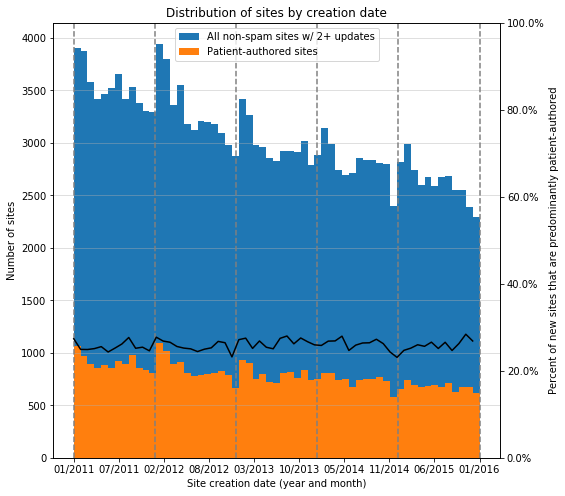

In [43]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of sites by creation date"
fig, ax = pl.subplots(num=title, figsize=(8,8))

start = 1293840000000  # 2011
end = 1451606400000  # 2016
bins = np.linspace(start, end, num=12 * 5)

sub_df = df[(df.createdAt >= start)&(df.createdAt <= end)&(df.total_journals >= 2)&(df.isSpam.isna())]

plt.axvline(start, color='gray', linestyle='--')
plt.axvline(1325376000000, color='gray', linestyle='--')
plt.axvline(1356998400000, color='gray', linestyle='--')
plt.axvline(1388534400000, color='gray', linestyle='--')
plt.axvline(1420070400000, color='gray', linestyle='--')
plt.axvline(end, color='gray', linestyle='--')

# Plot all sites, even those with only 1 journal
#plt.hist(df[(df.createdAt >= start)&(df.createdAt <= end)&(df.total_journals >= 1)&(df.isSpam.isna())].createdAt, 
#         bins=bins, range=(0,1), label="All non-spam sites")


total_bin_counts, bins, _ = plt.hist(sub_df.createdAt, 
                                     bins=bins, range=(0,1), label="All non-spam sites w/ 2+ updates")
patient_bin_counts, bins, _ = plt.hist(sub_df[sub_df.site_patient_proportion >= 0.5].createdAt, 
                                       bins=bins, range=(0,1), label="Patient-authored sites")

ax = plt.gca()
ax.set_xticks(np.linspace(start, end, num=10))
#ax.set_xticklabels(["%.1f" % ((x - start) / 1000 / 60 / 60 / 24 / 30) for x in  ax.get_xticks()])
ax.set_xticklabels([datetime.utcfromtimestamp(x / 1000).strftime('%m/%Y') for x in  ax.get_xticks()])
#ax = plt.gca()

#for i, bin_count in enumerate(bin_counts):
#    pct = bin_count / len(x) * 100
#    ax.text((bins[i] + bins[i+1]) / 2, bin_count, "%.2f%%" % pct, 
#            horizontalalignment='center', verticalalignment='bottom', fontsize=16)

patient_proportions = patient_bin_counts / total_bin_counts
ax2 = plt.gca().twinx()
ax2.set_ylim(0, 1)
ax2.plot(bins[:-1], patient_proportions, color='black')
ax2.set_yticklabels(['{:,.1%}'.format(y) for y in  ax2.get_yticks()])
ax2.set_ylabel("Percent of new sites that are predominantly patient-authored")
print("%.2f%% of new sites each month will turn out to be predominantly patient-authored." % (np.mean(patient_proportions) * 100))

ax.set_title(title)
ax.set_xlabel("Site creation date (year and month)")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

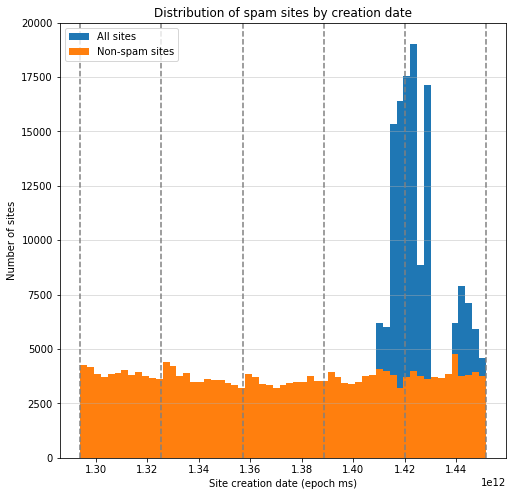

In [44]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of spam sites by creation date"
fig, ax = pl.subplots(num=title, figsize=(8,8))

start = 1293840000000  # 2011
end = 1451606400000  # 2016
bins = np.linspace(start, end, num=12 * 5)

sub_df = df[(df.createdAt >= start)&(df.createdAt <= end)]

plt.axvline(start, color='gray', linestyle='--')
plt.axvline(1325376000000, color='gray', linestyle='--')
plt.axvline(1356998400000, color='gray', linestyle='--')
plt.axvline(1388534400000, color='gray', linestyle='--')
plt.axvline(1420070400000, color='gray', linestyle='--')
plt.axvline(end, color='gray', linestyle='--')

plt.hist(sub_df.createdAt, bins=bins, range=(0,1), label="All sites")
plt.hist(sub_df[sub_df.isSpam.isna()].createdAt, bins=bins, range=(0,1), label="Non-spam sites")

ax.set_title(title)
ax.set_xlabel("Site creation date (epoch ms)")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

## Instrumental support analysis

Criteria:

- healthCondition_category == 'Cancer'
- \>= 3 total_journals
- createdAt > June 3, 2013  (ms: 1370048400000)
- createdAt < June 3, 2016  (ms: 1464742800000)

Note: This produces a slightly different set of sites than those used in the actual instrumental support work.

The totals reported in the paper are: 19,535 unique sites with 635,777 total journal updates.

In [11]:
is_df = df[(df.healthCondition_category == 'Cancer')&\
           (df.total_journals >= 3)&\
           (df.createdAt >= 1370048400000)&\
           (df.createdAt <= 1464742800000)]
len(is_df), np.sum(is_df.total_journals)hungary


(19916, 660630)

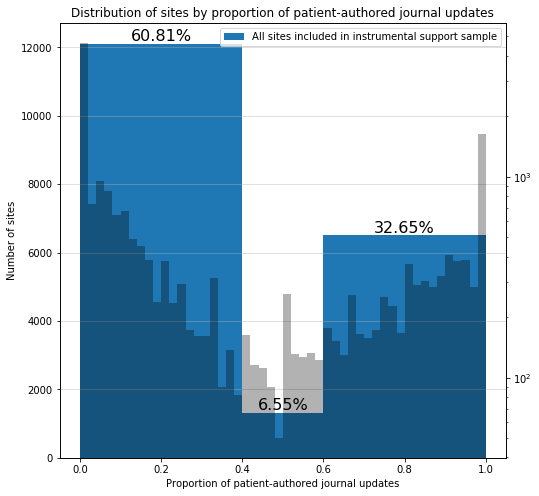

In [12]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of sites by proportion of patient-authored journal updates"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = is_df.site_patient_proportion

lower_thresh = 0.4
upper_thresh = 0.6

bin_counts, bins, _ = plt.hist(x, bins=[0, lower_thresh, upper_thresh, 1], range=(0,1), label="All sites included in instrumental support sample")
#plt.hist(is_df.site_patient_proportion, bins=[0, lower_thresh, upper_thresh, 1], range=(0,1), label="All sites", alpha=0.6)
ax = plt.gca()

for i, bin_count in enumerate(bin_counts):
    pct = bin_count / len(x) * 100
    ax.text((bins[i] + bins[i+1]) / 2, bin_count, "%.2f%%" % pct, 
            horizontalalignment='center', verticalalignment='bottom', fontsize=16)

ax2 = plt.gca().twinx()
ax2.hist(x, bins=50, range=(0,1), label="Detail", log=True, color='black', alpha=0.3)

ax.set_title(title)
ax.set_xlabel("Proportion of patient-authored journal updates")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

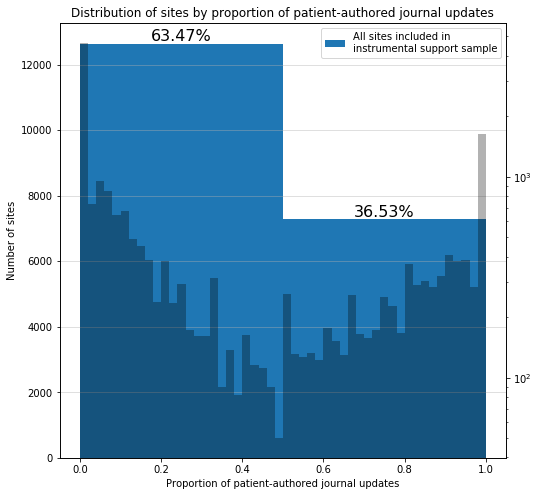

array([12640.,  7276.])

In [13]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of sites by proportion of patient-authored journal updates"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = is_df.site_patient_proportion

upper_thresh = 0.5

bin_counts, bins, _ = plt.hist(x, bins=[0, upper_thresh, 1], range=(0,1), label="All sites included in\ninstrumental support sample")
for i, bin_count in enumerate(bin_counts):
    pct = bin_count / len(x) * 100
    ax.text((bins[i] + bins[i+1]) / 2, bin_count, "%.2f%%" % pct, 
            horizontalalignment='center', verticalalignment='bottom', fontsize=16)

ax2 = plt.gca().twinx()
ax2.hist(x, bins=50, range=(0,1), label="Detailed distribution", log=True, color='black', alpha=0.3)

ax.set_title(title)
ax.set_xlabel("Proportion of patient-authored journal updates")
ax.set_ylabel("Number of sites")

ax.legend()
#ax2.legend(loc=4)

ax.grid(axis="y", alpha=0.5)
plt.show()
bin_counts

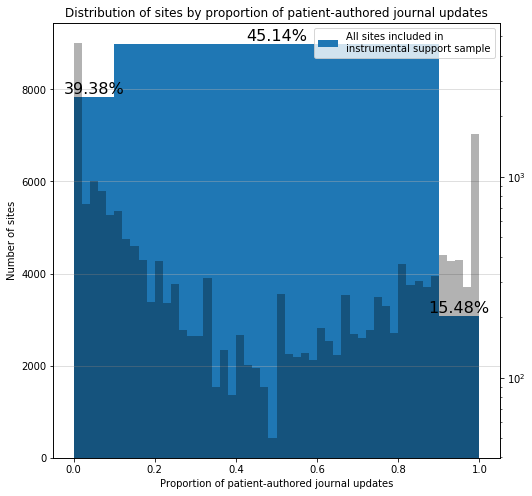

In [14]:
# Plot the distribution of journal predicted probabilities
title = "Distribution of sites by proportion of patient-authored journal updates"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = is_df[is_df.total_journals >= 1].site_patient_proportion

lower_thresh = 0.10
upper_thresh = 0.90

bin_counts, bins, _ = plt.hist(x, bins=[0, lower_thresh, upper_thresh, 1], range=(0,1), label="All sites included in\ninstrumental support sample")
ax = plt.gca()

for i, bin_count in enumerate(bin_counts):
    pct = bin_count / len(x) * 100
    ax.text((bins[i] + bins[i+1]) / 2, bin_count, "%.2f%%" % pct, 
            horizontalalignment='center', verticalalignment='bottom', fontsize=16)

ax2 = plt.gca().twinx()
ax2.hist(x, bins=50, range=(0,1), label="Detailed distribution", log=True, color='black', alpha=0.3)

    
ax.set_title(title)
ax.set_xlabel("Proportion of patient-authored journal updates")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [15]:
is_site_ids = set(is_df.site_id)
len(is_site_ids)

19916

In [16]:
is_journal_df = journal_df[journal_df.site_id.isin(is_site_ids)]
len(is_journal_df) / len(journal_df)

0.044128642176048456

In [17]:
assert len(set(is_journal_df.site_id)) == len(is_site_ids)

In [18]:
# compute time-since-start-of-site for each update

journal_starts = {row.site_id: row.created_at for ind, row in is_journal_df[is_journal_df.site_index == 0].iterrows()}

#print(len(journal_starts), len(set(is_journal_df.site_id)))
#print(len(is_journal_df[is_journal_df.site_index == 0]), len(is_journal_df))
#assert len(journal_starts) == len(set(is_journal_df.site_id))

def get_seconds_since_first_journal(row):
    if row.site_id not in journal_starts:
        # a few sites don't start at index 0, if for example the first post was very short
        start_of_journal = is_journal_df[is_journal_df.site_id == row.site_id].iloc[0].created_at
    else:
        start_of_journal = journal_starts[row.site_id]
    time_elapsed = row.created_at - start_of_journal
    return time_elapsed / 1000

is_journal_df['seconds_since_first_journal'] = \
    is_journal_df.apply(get_seconds_since_first_journal, axis=1)

/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
# compute the pct-of-site for each update

# first build a map of site_id to the number of updates on a site, as marked by the index of the last non-trivial upate
journal_sites = {site_id: np.max(group.site_index) + 1 for site_id, group in tqdm(is_journal_df.groupby(by='site_id'))}

# then, compute the percentage relative to that number of updates
is_journal_df['pct_of_site_updates_elapsed'] = \
    is_journal_df.apply(lambda row: (row.site_index + 1) * (1 / journal_sites[row.site_id]), axis=1)

100%|██████████| 19916/19916 [00:10<00:00, 1960.07it/s]
/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


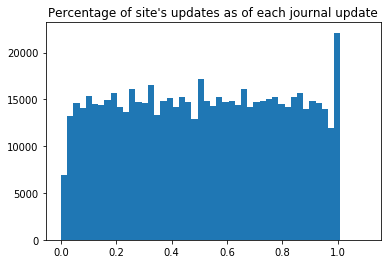

In [23]:
# Validation: pct_of_site_updates_elapsed plot is symmetric
# Note the low point and high point at the start and end of a site; few sites are long enough to have low % updates, but all sites have a 100% update
plt.hist(is_journal_df.pct_of_site_updates_elapsed, bins=np.linspace(0, 1.1, 50))
plt.title("Percentage of site's updates as of each journal update")
plt.show()

In [121]:
# Validation: A very high percent of updates occur more than 0 seconds after the first journal update on a site
len(is_journal_df[is_journal_df.seconds_since_first_journal > 0]) / len(is_journal_df)

0.9682908738628279

In [117]:
# example of site not having a journal with site_index == 0...
is_journal_df[is_journal_df.site_id == 733817]

,site_id,journal_oid,author_type_raw_prediction,author_type_prediction_prob,is_predicted_patient,created_at,site_index,user_id
13697090,733817,536fa267af3d79ee3d88d2af,3.073120,0.955770,True,1399824999000,2,26068343
13735575,733817,53935fa8cb16b41c435db95c,3.577724,0.972820,True,1402167208000,3,26068343
13804864,733817,53dff691a589b45c7e5a0b3e,2.289774,0.908027,True,1407186577000,4,26068343
13842806,733817,540da820a589b4f60d95be1d,-3.463351,0.030373,False,1410181152000,5,26068343
13845284,733817,54105d568b5cd30611ad62ba,-2.627765,0.067373,False,1410358614000,6,26068343
13847708,733817,541321258b5cd33e3e981b2d,-1.585649,0.169997,False,1410539813000,7,26068343
13849271,733817,5415ac27cb16b443056e22a6,-3.574440,0.027267,False,1410706471000,8,26068343
13852500,733817,541992c7af3d798643de20fe,-1.651264,0.160938,False,1410962119000,9,26068343


/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


On average, 33.08% of updates on sites in the instrumental support sample are patient-authored.


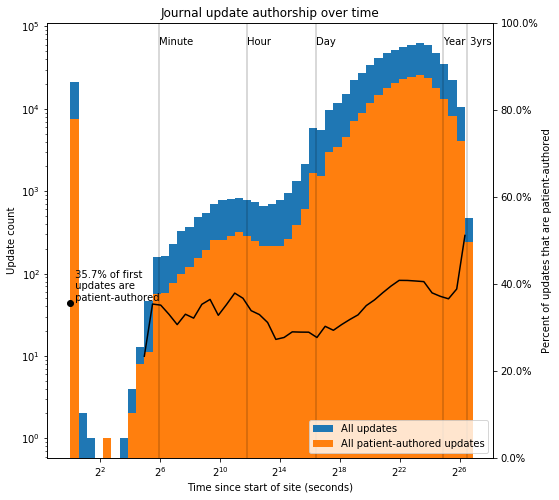

In [182]:

title = "Journal update authorship over time"
fig, ax = pl.subplots(num=title, figsize=(8,8))

end_of_hist = 60 * 60 * 24 * 365 *4 # 4 years
logbins = np.logspace(np.log2(1), np.log2(end_of_hist), num=50, base=2, endpoint=True)
total_bin_counts, bins, _ = ax.hist(is_journal_df.seconds_since_first_journal + 1, log=True, bins=logbins,
                                   label='All updates')
patient_bin_counts, bins, _ = ax.hist(is_journal_df[is_journal_df.is_predicted_patient].seconds_since_first_journal + 1, log=True, bins=logbins,
                                     label='All patient-authored updates')
ax.set_xscale('log', nonposx='clip', basex=2)

ax.set_xlabel("Time since start of site (seconds)")
ax.set_ylabel("Update count")
ax.set_title(title)

# add semantically interpretable time moments
alpha=0.2
ax.axvline(60, color='black', alpha=alpha)
ax.axvline(60 * 60, color='black', alpha=alpha)
ax.axvline(60 * 60 * 24, color='black', alpha=alpha)
ax.axvline(60 * 60 * 24 * 365, color='black', alpha=alpha)
ax.axvline(60 * 60 * 24 * 365 * 3, color='black', alpha=alpha)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.95))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
ax.text(60, text_y, 'Minute', color='black')
ax.text(60 * 60, text_y, 'Hour', color='black')
ax.text(60 * 60 * 24, text_y, 'Day', color='black')
ax.text(60 * 60 * 24 * 365, text_y, 'Year', color='black')
ax.text(60 * 60 * 24 * 365 * 3, text_y, ' 3yrs', color='black')

patient_proportions = patient_bin_counts / total_bin_counts
patient_proportions = np.nan_to_num(patient_proportions)
ax2 = plt.gca().twinx()
ax2.set_ylim(0, 1)
ax2.plot(bins[9:-1], patient_proportions[9:], color='black')
ax2.scatter(bins[0], patient_proportions[0], color='black')
ax2.text(bins[0] * 1.1, patient_proportions[0], ' %.1f%% of first\n updates are\n patient-authored' % (patient_proportions[0] * 100),
         horizontalalignment='left', verticalalignment='bottom')
ax2.set_yticklabels(['{:,.1%}'.format(y) for y in  ax2.get_yticks()])
ax2.set_ylabel("Percent of updates that are patient-authored")
print("On average, %.2f%% of updates on sites in the instrumental support sample are patient-authored." % (np.mean(patient_proportions) * 100))

ax.legend(loc=4)

plt.show()

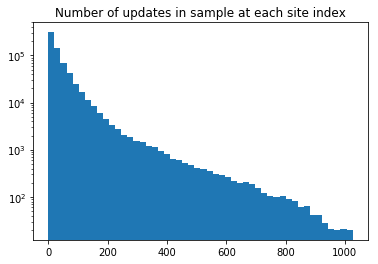

In [167]:
bin_counts, bins, _ = plt.hist(is_journal_df.site_index, log=True, bins=50)
plt.title("Number of updates in sample at each site index")
plt.show()

100.00% of updates in the instrumental support sample are included.
On average, 32.97% of updates on sites in the instrumental support sample are patient-authored.


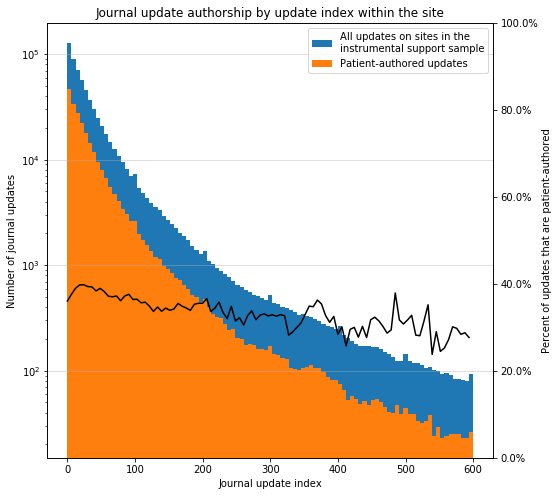

In [189]:
# Plot the proportion of patient-authorship by the index of the update within the site
# I have no particular prior about this, but it seems like this proportion is relatively stable.
title = "Journal update authorship by update index within the site"
fig, ax = pl.subplots(num=title, figsize=(8,8))

bins = np.linspace(0, 600, num=100)

multi_author_sites = set(is_df[(is_df.site_patient_proportion > 0.1)&(is_df.site_patient_proportion < 0.9)].site_id)
sub_df = is_journal_df[is_journal_df.site_id.isin(multi_author_sites)]
sub_df = is_journal_df
print("%.2f%% of updates in the instrumental support sample are included." % (len(sub_df) / len(is_journal_df) * 100))

total_bin_counts, bins, _ = plt.hist(sub_df.site_index, 
                                     bins=bins, range=(0,1), label="All updates on sites in the\ninstrumental support sample", log=True)
patient_bin_counts, bins, _ = plt.hist(sub_df[sub_df.is_predicted_patient].site_index, 
                                       bins=bins, range=(0,1), label="Patient-authored updates", log=True)

patient_proportions = patient_bin_counts / total_bin_counts
ax2 = plt.gca().twinx()
ax2.set_ylim(0, 1)
ax2.plot(bins[:-1], patient_proportions, color='black')
ax2.set_yticklabels(['{:,.1%}'.format(y) for y in  ax2.get_yticks()])
ax2.set_ylabel("Percent of updates that are patient-authored")
print("On average, %.2f%% of updates on sites in the instrumental support sample are patient-authored." % (np.mean(patient_proportions) * 100))

ax.set_title(title)
ax.set_xlabel("Journal update index")
ax.set_ylabel("Number of journal updates")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

48.85% of updates in the instrumental support sample are included.
On average, 47.77% of updates on sites in the instrumental support sample are patient-authored.


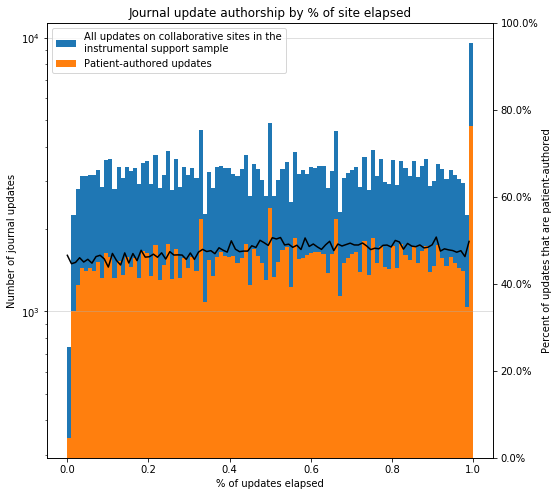

In [30]:
# Plot the proportion of patient-authorship by the percentage of journals we've seen
# TODO Based on a new column...
title = "Journal update authorship by % of site elapsed"
fig, ax = pl.subplots(num=title, figsize=(8,8))

bins = np.linspace(0, 1, num=100)

multi_author_sites = set(is_df[(is_df.site_patient_proportion > 0.1)&(is_df.site_patient_proportion < 0.9)&(is_df.total_journals >= 3)].site_id)
sub_df = is_journal_df[is_journal_df.site_id.isin(multi_author_sites)]
#sub_df = is_journal_df
print("%.2f%% of updates in the instrumental support sample are included." % (len(sub_df) / len(is_journal_df) * 100))

total_bin_counts, bins, _ = plt.hist(sub_df.pct_of_site_updates_elapsed, 
                                     bins=bins, range=(0,1), label="All updates on collaborative sites in the\ninstrumental support sample", log=True)
patient_bin_counts, bins, _ = plt.hist(sub_df[sub_df.is_predicted_patient].pct_of_site_updates_elapsed, 
                                       bins=bins, range=(0,1), label="Patient-authored updates", log=True)

patient_proportions = patient_bin_counts / total_bin_counts
ax2 = plt.gca().twinx()
ax2.set_ylim(0, 1)
ax2.plot(bins[:-1], patient_proportions, color='black')
ax2.set_yticklabels(['{:,.1%}'.format(y) for y in  ax2.get_yticks()])
ax2.set_ylabel("Percent of updates that are patient-authored")
print("On average, %.2f%% of updates on sites in the instrumental support sample are patient-authored." % (np.mean(patient_proportions) * 100))

ax.set_title(title)
ax.set_xlabel("% of updates elapsed")
ax.set_ylabel("Number of journal updates")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

100.00% of updates in the instrumental support sample are included.
On average, 37.49% of updates on sites in the instrumental support sample are patient-authored.


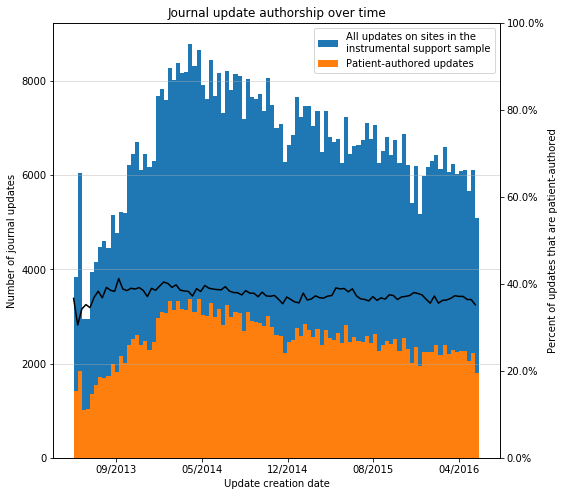

In [31]:
# Plot authorship over time; we would expect this proportion to be relatively static, which it is.
title = "Journal update authorship over time"
fig, ax = pl.subplots(num=title, figsize=(8,8))

bins = np.linspace(1370048400000,1464742800000, num=100)

multi_author_sites = set(is_df[(is_df.site_patient_proportion > 0.1)&(is_df.site_patient_proportion < 0.9)].site_id)
sub_df = is_journal_df[is_journal_df.site_id.isin(multi_author_sites)]
sub_df = is_journal_df
print("%.2f%% of updates in the instrumental support sample are included." % (len(sub_df) / len(is_journal_df) * 100))

total_bin_counts, bins, _ = plt.hist(sub_df.created_at,
                                     bins=bins, range=(0,1), label="All updates on sites in the\ninstrumental support sample")
patient_bin_counts, bins, _ = plt.hist(sub_df[sub_df.is_predicted_patient].created_at, 
                                       bins=bins, range=(0,1), label="Patient-authored updates")

ax = plt.gca()
ax.set_xticklabels([datetime.utcfromtimestamp(x / 1000).strftime('%m/%Y') for x in  ax.get_xticks()])

patient_proportions = patient_bin_counts / total_bin_counts
ax2 = plt.gca().twinx()
ax2.set_ylim(0, 1)
ax2.plot(bins[:-1], patient_proportions, color='black')
ax2.set_yticklabels(['{:,.1%}'.format(y) for y in  ax2.get_yticks()])
ax2.set_ylabel("Percent of updates that are patient-authored")
print("On average, %.2f%% of updates on sites in the instrumental support sample are patient-authored." % (np.mean(patient_proportions) * 100))

ax.set_title(title)
ax.set_xlabel("Update creation date")
ax.set_ylabel("Number of journal updates")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()